Dataset for classification from https://www.kaggle.com/andrewmvd/breast-cancer-cell-segmentation

Dataset for segmentation from https://zenodo.org/record/1175282#.Xl_4nZMzZQJ

This notebook uses code from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install -U segmentation-models-pytorch

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from skimage.io import imread
import os
from skimage.transform import resize

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Segmentation

##Loading data

In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/breast_cancer'

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'x_train')
y_train_dir = os.path.join(DATA_DIR, 'y_train')

x_valid_dir = os.path.join(DATA_DIR, 'x_val')
y_valid_dir = os.path.join(DATA_DIR, 'y_val')

x_test_dir = os.path.join(DATA_DIR, 'x_test')
y_test_dir = os.path.join(DATA_DIR, 'y_test')

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
class Dataset(BaseDataset):   

    CLASSES = ['breast_cancer']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [masks_dir + '/' +image_id for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)
        masks = [(mask != v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

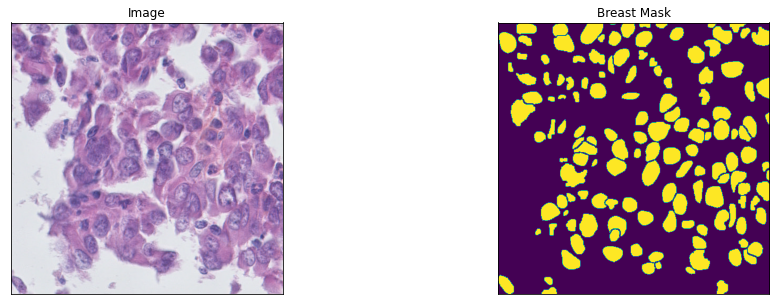

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['breast_cancer'])

image, mask = dataset[11]
visualize(
    image=image, 
    breast_mask=mask.squeeze(),
)

In [ ]:
def get_training_augmentation():
    train_transform = [
        #albu.Resize(height=256, width=256)
    #    albu.RandomSizedCrop(min_max_height=(160, 384), height=256, width=256),
        albu.ColorJitter(),
        albu.RandomRotate90(p=1),
        albu.Transpose(p=0.5),
        #albu.Normalize(),
        albu.VerticalFlip(p=0.5),
        albu.HorizontalFlip(p=0.5),
        albu.OneOf(
    [
        albu.RandomSizedCrop(min_max_height=(160, 384), height=256, width=256),
        albu.CropNonEmptyMaskIfExists(height=256, width=256)
    ], p=1
  )
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
       #  albu.PadIfNeeded(384, 480),
      #  albu.RandomSizedCrop(min_max_height=(160, 384), height=256, width=256),
        #albu.Normalize(),
       # albu.Resize(height=256, width=256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Normalize(),
        albu.Lambda(image=preprocessing_fn),
       # albu.Resize(height=256, width=256),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

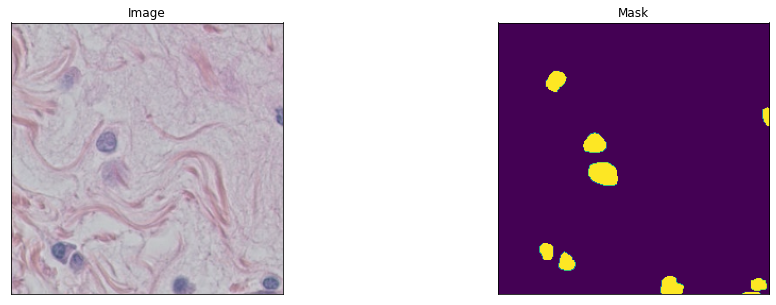

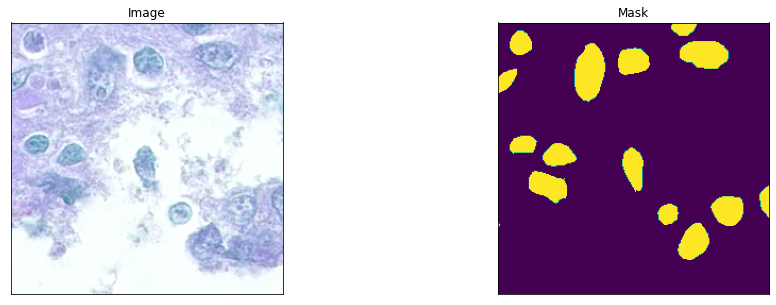

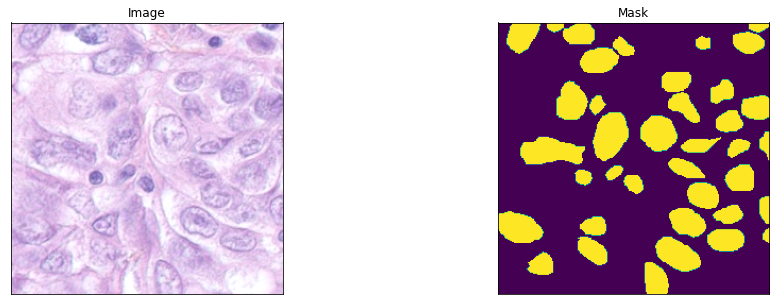

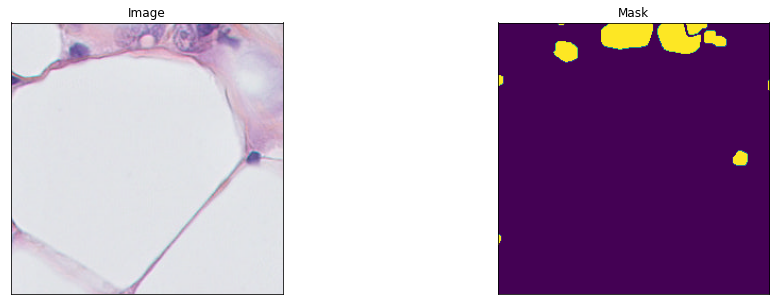

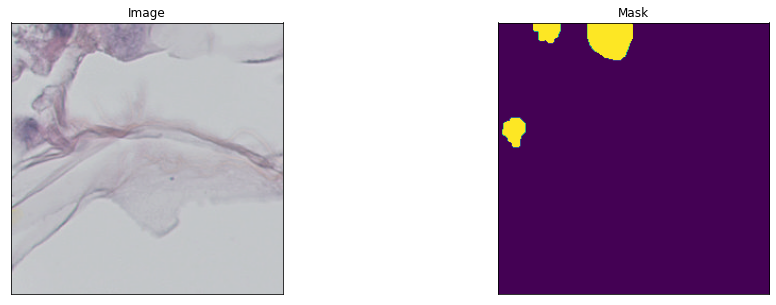

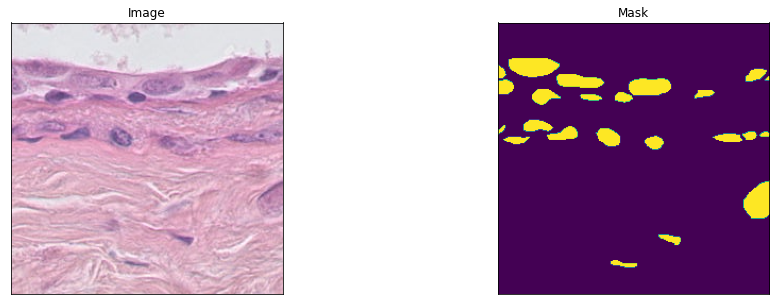

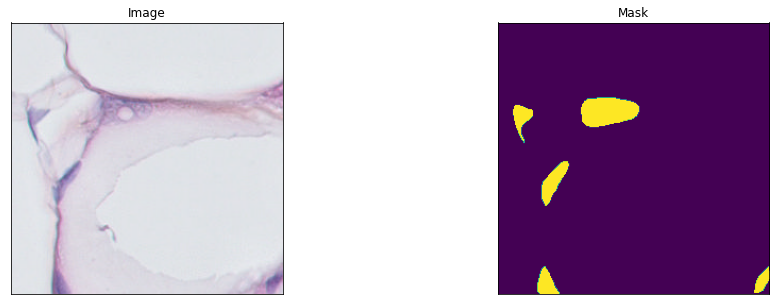

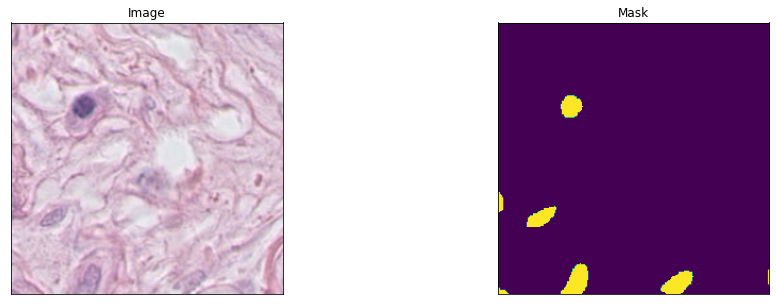

In [ ]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
    classes=['breast_cancer'],
)

# same image with different random transforms
for i in range(8):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze(-1))

In [ ]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['breast_cancer']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES),
    in_channels=3,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)


valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
loss_train = []
loss_val = []
IOU_train = []
IOU_val = []
max_score = 0

for i in range(0, 400):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    loss_train.append(valid_logs['dice_loss'])
    loss_val.append(train_logs['dice_loss'])
    IOU_train.append(valid_logs['iou_score'])
    IOU_val.append(train_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 200:
      optimizer.param_groups[0]['lr'] = 1e-5
      print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 13/13 [00:00<00:00, 16.48it/s, dice_loss - 0.7931, iou_score - 0.0314]
Model saved!

Epoch: 1
valid: 100%|██████████| 13/13 [00:00<00:00, 15.96it/s, dice_loss - 0.8076, iou_score - 0.02012]

Epoch: 2
valid: 100%|██████████| 13/13 [00:00<00:00, 16.39it/s, dice_loss - 0.8154, iou_score - 0.03082]

Epoch: 3
valid: 100%|██████████| 13/13 [00:00<00:00, 16.08it/s, dice_loss - 0.8159, iou_score - 0.03552]
Model saved!

Epoch: 4
valid: 100%|██████████| 13/13 [00:00<00:00, 16.28it/s, dice_loss - 0.8173, iou_score - 0.04268]
Model saved!

Epoch: 5
valid: 100%|██████████| 13/13 [00:00<00:00, 16.19it/s, dice_loss - 0.8143, iou_score - 0.05179]
Model saved!

Epoch: 6
valid: 100%|██████████| 13/13 [00:00<00:00, 16.43it/s, dice_loss - 0.802, iou_score - 0.06096]
Model saved!

Epoch: 7
valid: 100%|██████████| 13/13 [00:00<00:00, 16.25it/s, dice_loss - 0.7935, iou_score - 0.07653]
Model saved!

Epoch: 8
valid: 100%|██████████| 13/13 [00:00<00:00, 15.71it/s, dice_loss - 0.7873, i

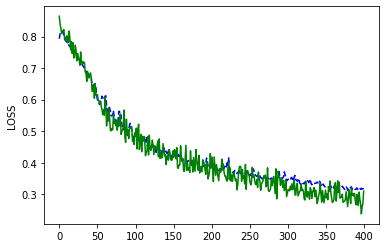

In [ ]:
plt.plot(range(400),loss_train,'b--',range(400),loss_val,'g')
plt.ylabel('LOSS')
plt.show()

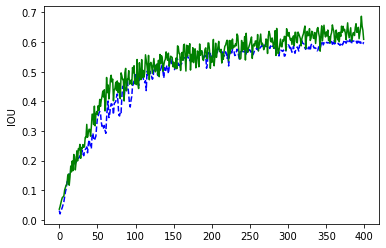

In [ ]:
plt.plot(range(400),IOU_train,'b--',range(400),IOU_val,'g')
plt.ylabel('IOU')
plt.show()

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 7/7 [00:00<00:00, 19.99it/s, dice_loss - 0.3073, iou_score - 0.6419]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

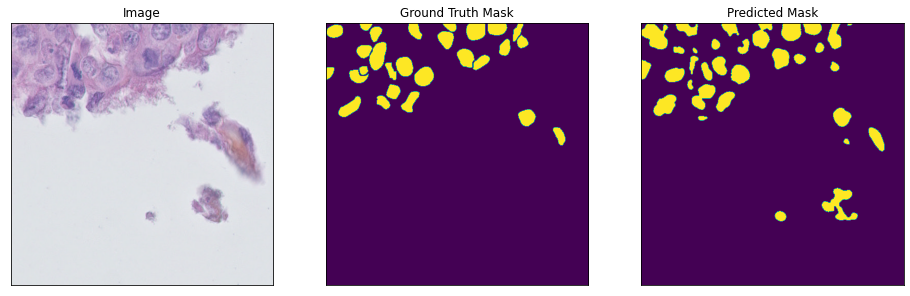

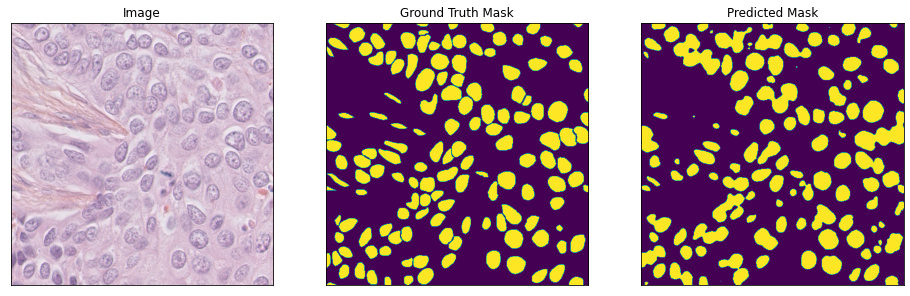

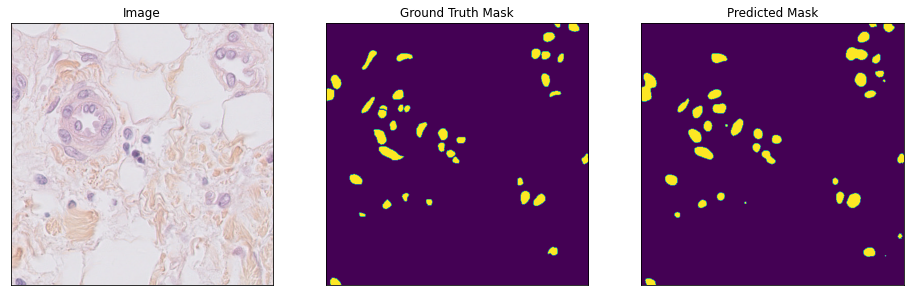

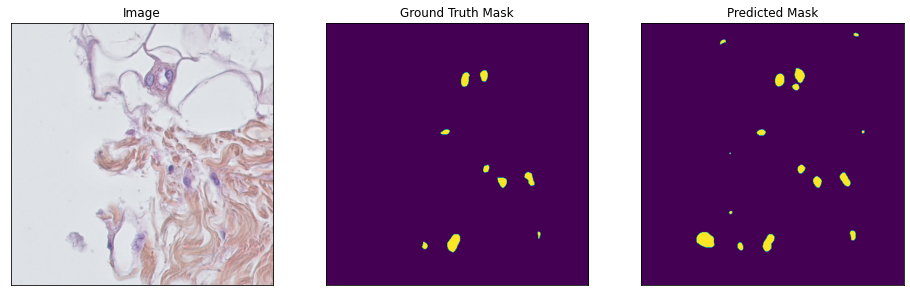

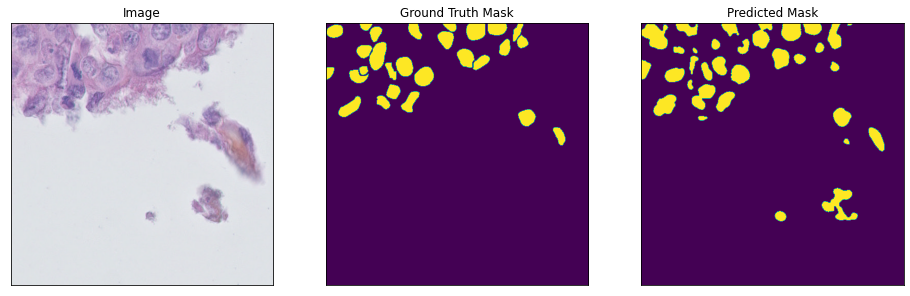

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]#.astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

#Classification

##preprocessing

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#!kaggle datasets download -d andrewmvd/breast-cancer-cell-segmentation
#!unzip \*.zip  && rm *.zip

In [ ]:
images_benign = []
images_malignant = []
root = "/content/gdrive/MyDrive/Kaggle"
for root, dirs, files in os.walk(root):
    if root.endswith('Images'):
      for file in files:
        if file.endswith(".tif") and file.find("benign") != -1:
          images_benign.append(imread(os.path.join(root, file)))
        elif file.endswith(".tif") and file.find("malignant") != -1:
          images_malignant.append(imread(os.path.join(root, file)))


In [ ]:
len(images_benign),len(images_malignant)

(32, 26)

In [ ]:
size = (256, 256)
X_1 = [resize(x_1, size, mode='constant', anti_aliasing=True,) for x_1 in images_benign]
X_2 = [resize(x_2, size, mode='constant', anti_aliasing=True)  for x_2 in images_malignant]

In [ ]:
benign_label = np.zeros(len(images_benign))
malign_label = np.ones(len(images_malignant))
y = np.concatenate((benign_label, malign_label), axis = 0)
X = np.concatenate((X_1, X_2), axis = 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, test_size=0.33, random_state=42)

In [ ]:
len(X_train),len(X_val), len(X_test), len(y_train), len(y_val),len(y_test)

(25, 13, 20, 25, 13, 20)

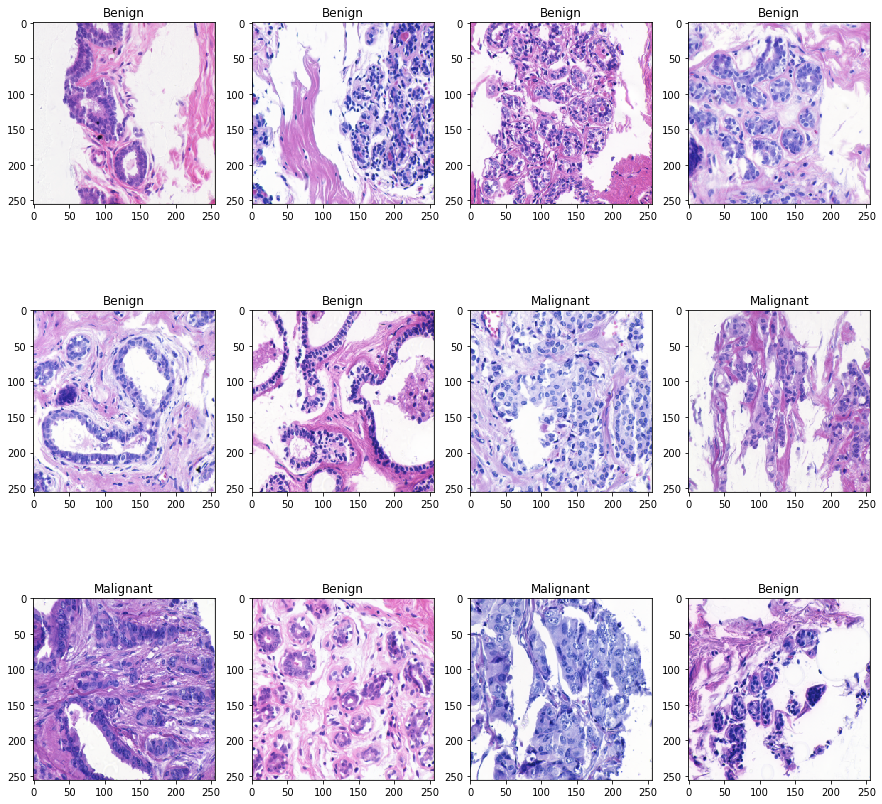

In [ ]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [ ]:
BATCH_SIZE = 15
train_iterator = DataLoader(list(zip(X_train, y_train)),
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE,
                            )

valid_iterator = DataLoader(list(zip(X_val, y_val)),
                                 batch_size = BATCH_SIZE)

test_iterator = DataLoader(list(zip(X_test, y_test)),
                                batch_size = BATCH_SIZE)

##Learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import torchvision.models as models

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,689,512 trainable parameters


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc = nn.Linear(512,2)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr =1e-4)
criterion = nn.CrossEntropyLoss()
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x.permute(0,3,2,1).float())

        y_pred = y_pred.float()
        y = y.type(torch.LongTensor)
        
        loss = criterion(y_pred.cuda(), y.cuda())
        
        acc = calculate_accuracy(y_pred.cuda(), y.cuda())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x.permute(0,3,2,1).float())

            y_pred = y_pred.float().to(device)
            y = y.type(torch.LongTensor).to(device)

            loss = criterion(y_pred.cuda(), y.cuda())

            acc = calculate_accuracy(y_pred.cuda(), y.cuda())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 20
device = 'cuda'
model = model.to(device)
best_valid_loss = float('inf')
device = 'cuda'
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.705 | Train Acc: 53.33%
	 Val. Loss: 0.778 |  Val. Acc: 38.46%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.109 | Train Acc: 100.00%
	 Val. Loss: 0.793 |  Val. Acc: 46.15%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.028 | Train Acc: 100.00%
	 Val. Loss: 0.763 |  Val. Acc: 46.15%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.013 | Train Acc: 100.00%
	 Val. Loss: 0.718 |  Val. Acc: 61.54%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.007 | Train Acc: 100.00%
	 Val. Loss: 0.670 |  Val. Acc: 69.23%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.006 | Train Acc: 100.00%
	 Val. Loss: 0.627 |  Val. Acc: 69.23%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.004 | Train Acc: 100.00%
	 Val. Loss: 0.593 |  Val. Acc: 69.23%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.007 | Train Acc: 100.00%
	 Val. Loss: 0.565 |  Val. Acc: 69.23%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.002 | Train Acc: 100.00%
	 Val. Loss: 0.542 |  Val. Acc: 69.23%
Epoch: 10 | Epoch Ti

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.260 | Test Acc: 93.33%


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command
rm -r Images Masks
!kaggle datasets download -d andrewmvd/breast-cancer-cell-segmentation
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip
ls -l
for root, dirs, files in os.walk("/content/gdrive/MyDrive/Kaggle"):
  print(files)

  from skimage.io import imread
import os
images = []
masks = []
file_name_1 = []
file_name_2 = []
root = "/content/gdrive/MyDrive/Kaggle"
for root, dirs, files in os.walk(root):
    if root.endswith('Images'):
      for file in files:
        if file.endswith(".tif"):
          images.append(imread(os.path.join(root, file)))
          file_name_1.append(file)
    if root.endswith('Masks'):
      for file in files:
        if file.endswith(".TIF"):
          masks.append(imread(os.path.join(root, file)))
          file_name_2.append(file)


          from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [30, 40])
print(len(tr), len(val), len(ts))


import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size) #shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size)# shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size)# shuffle=True)

SyntaxError: ignored

In [ ]:
increased_dataset = torch.utils.data.ConcatDataset([dataset,X_train])
aug_X_train = [dataset[i].numpy() for i in range (len(X_train))]
X_train_new = np.stack((aug_X_train,X_train))
from torch.utils.data import Dataset
class experimental_dataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item.permute(1,2,0)

transform = transforms.Compose([
   # transforms.ToPILImage(),
     transforms.ToTensor(),
     #transforms.RandomRotation(90),
   #  transforms.RandomCrop(256),
     transforms.RandomHorizontalFlip(),
   #  transforms.Scale(256),
     transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(0,2,3),
    # transforms.RandomAffine(20, scale = (1,3)),
  #   transforms.FiveCrop(30),
   #  transforms.RandomRotation(90)
  #   transforms.ToTensor(),
    ])
    

dataset = experimental_dataset(X_train,transform)